## Transfer Learning

With transfer learning, instead of starting the learning process from scratch, you start from patterns that have been learned when solving a new related problem. So we reuse initial and middle layers of our pre-trained model to re-train only final layers for our new task. A pre-trained model denotes a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve.

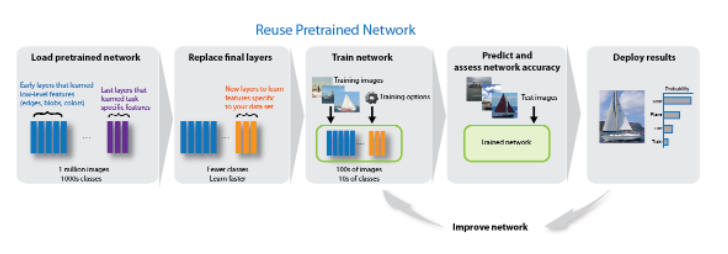

Fine tuning is a way of appliying or utilizing transfer learning. Specifically fine tuning is a process that takes a model that's already been trained for a given task and then tuning or tweaking that model to make it perform a second similiar task. If the two tasks are different and there will be some information that the model has learned that may not apply to our new task or there may be new information that the model needs to learn from the data regarding the new task that wasn't learned from the previous task. 



In this project it will be implemented a transfer learning approach by using weather dataset [1] for image classifitaion task. The dataset consists of a total of 1125 images which are maually labeled as cloudy, sunrise, rainy and sun shine. Pre-trained models will be used, which are ResNet and InceptionV3 available from Keras [2].

[1]: https://data.mendeley.com/datasets/4drtyfjtfy/1

[2]: https://keras.io/api/applications/

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions, InceptionV3
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
import os

In [4]:
# Create the models without including the final layer

model_res = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top = False)
model_inc = InceptionV3(weights='imagenet', input_shape=(224, 224, 3), include_top= False)


In [5]:
# Freeze the layers of both models

model_res.trainable = False
model_inc.trainable = False


In [6]:
# Add output layer to ResNet model. We have 4 classes so add a Dense layer with parameter 4.
"""
0 ---> Cloudy
1 ---> Rain
2 ---> Shine
3 ---> Sunrise
"""

inputs = keras.Input(shape=(224, 224, 3))
x = model_res.output

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(1024, activation='relu')(x)

# Classifier
outputs = keras.layers.Dense(4, activation="softmax")(x)
model_res = keras.Model(model_res.input, outputs)


In [7]:
# Add output layer to Inception model. We have 4 classes so add a Dense layer with parameter 4.
"""
0 ---> Cloudy
1 ---> Rain
2 ---> Shine
3 ---> Sunrise
"""

inputs = keras.Input(shape=(224, 224, 3))
x = model_inc(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
# Classifier
outputs = keras.layers.Dense(4, activation="softmax")(x)
model_inc = keras.Model(inputs, outputs)


In [9]:
# Compile the models

model_res.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model_inc.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])


In [3]:
# Create the dataset and make it ready to training by splitting it.

# Define the labels
labels = ["cloudy", "rain", "shine", "sunrise"]

# Choose a proper image size
img_size = 224

# Reads all images and returns splitted data

def get_splitted_data(train_split_rate):

    x_train = []
    y_train = []
    x_test = []
    y_test = []

    # For loop to read images in all 4 folders
    for label in labels:
        
        label_num = labels.index(label)
        
        path = f'dataset/{label}/'
        imgs = os.listdir(path)
        
        # Calculates the index that, as from it, data will be added into test arrays
        total_num = len(imgs)
        ind = train_split_rate * total_num
        
        counter = 0
        
        # For loop to read a specific folder
        for img_path in imgs:
            counter +=1
            
            img_path = path + img_path
            img = image.load_img(img_path, target_size=(img_size, img_size))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            img = np.array(x, dtype="object")
            
            # Do the splitting operation
            if counter < ind:
                x_train.append(img[0])
                y_train.append(label_num)
            
            else:
                x_test.append(img[0])
                y_test.append(label_num)
            
    
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

x_train, y_train, x_test, y_test = get_splitted_data(0.8)


In [10]:
# Convert datatypes to avoid problems

x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

# Fit ResNet model

history_res = model_res.fit(
    x_train,
    y_train,
    epochs=3,
    
    validation_data=(x_test, y_test),
)

# Fit Inception model
history_inc = model_inc.fit(
    x_train,
    y_train,
    epochs=3,
    
    validation_data=(x_test, y_test),
)

Epoch 1/3
29/29 [==============================] - 130s 4s/step - loss: 1.3761 - sparse_categorical_accuracy: 0.3188 - val_loss: 1.3637 - val_sparse_categorical_accuracy: 0.3202
Epoch 2/3
29/29 [==============================] - 108s 4s/step - loss: 1.3470 - sparse_categorical_accuracy: 0.3289 - val_loss: 1.3465 - val_sparse_categorical_accuracy: 0.3202
Epoch 3/3
29/29 [==============================] - 111s 4s/step - loss: 1.3248 - sparse_categorical_accuracy: 0.3367 - val_loss: 1.3344 - val_sparse_categorical_accuracy: 0.3816
Epoch 1/3
29/29 [==============================] - 65s 2s/step - loss: 0.9353 - sparse_categorical_accuracy: 0.6366 - val_loss: 0.5340 - val_sparse_categorical_accuracy: 0.8596
Epoch 2/3
29/29 [==============================] - 59s 2s/step - loss: 0.3493 - sparse_categorical_accuracy: 0.8952 - val_loss: 0.3805 - val_sparse_categorical_accuracy: 0.8860
Epoch 3/3
29/29 [==============================] - 60s 2s/step - loss: 0.2633 - sparse_categorical_accuracy: 0.9

In [11]:
# Unfreeze the models
model_res.trainable = True
model_inc.trainable = True

# Recompile the models
model_res.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model_inc.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])



In [12]:
# Fit ResNet model after unfreezing all the layers
print("ResNet model has been started training\n")

history_res_new = model_res.fit(
    x_train,
    y_train,
    epochs=3,
    
    validation_data=(x_test, y_test),
)

print("InceptionV3 model has been started training\n")

# Fit Inception model after unfreezing all the layers
history_inc_new = model_inc.fit(
    x_train,
    y_train,
    epochs=3,
    
    validation_data=(x_test, y_test),
)

ResNet model has been started training

Epoch 1/3
29/29 [==============================] - 461s 16s/step - loss: 0.9669 - sparse_categorical_accuracy: 0.6310 - val_loss: 1.3782 - val_sparse_categorical_accuracy: 0.3202
Epoch 2/3
29/29 [==============================] - 429s 15s/step - loss: 0.3399 - sparse_categorical_accuracy: 0.9465 - val_loss: 1.4421 - val_sparse_categorical_accuracy: 0.3202
Epoch 3/3
29/29 [==============================] - 438s 15s/step - loss: 0.1797 - sparse_categorical_accuracy: 0.9766 - val_loss: 1.5827 - val_sparse_categorical_accuracy: 0.3158
InceptionV3 model has been started training

Epoch 1/3
29/29 [==============================] - 247s 8s/step - loss: 0.1328 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.2119 - val_sparse_categorical_accuracy: 0.9474
Epoch 2/3
29/29 [==============================] - 223s 8s/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.1851 - val_sparse_categorical_accuracy: 0.9649
Epoch 3/3
29/29 [=====

In [15]:
# Save model

model_res.save('saved_models/weather_pred_model_red')

model_inc.save('saved_models/weather_pred_model_inc')

INFO:tensorflow:Assets written to: saved_models/weather_pred_model_red\assets


INFO:tensorflow:Assets written to: saved_models/weather_pred_model_red\assets


INFO:tensorflow:Assets written to: saved_models/weather_pred_model_inc\assets


INFO:tensorflow:Assets written to: saved_models/weather_pred_model_inc\assets


NameError: name 'history_res' is not defined

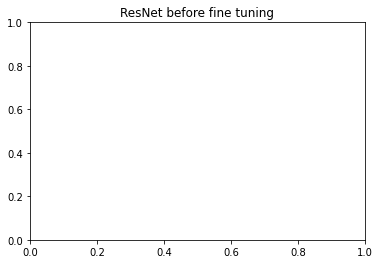

In [9]:
# Plot loss and accuracy for both models. Labels indicate if the graph plotted belongs to a model before fine tuning is applied
# or after fine tuning is applied

import matplotlib.pyplot as plt

plt.title("ResNet before fine tuning")
plt.plot(history_res.history['loss'], label='loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

In ResNet, loss is getting smaller as expected but it's still far from fair.

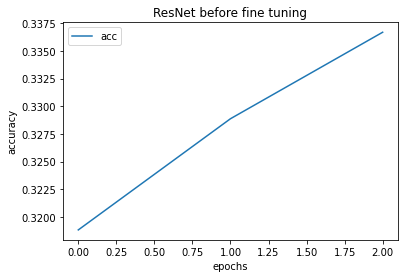

In [18]:
plt.title("ResNet before fine tuning")
plt.plot(history_res.history['sparse_categorical_accuracy'], label='acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

Accuracy of ResNet is getting greater as expected but it's not high as desired. I tried various ways including adding more layers etc. but it had not been improved even got worse.

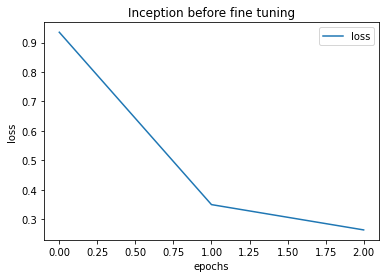

In [19]:
plt.title("Inception before fine tuning")
plt.plot(history_inc.history['loss'], label='loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

Loss is getting really small as desired. InceptionV3 model works better than ResNet.

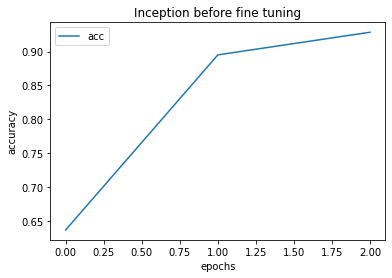

In [20]:
plt.title("Inception before fine tuning")
plt.plot(history_inc.history['sparse_categorical_accuracy'], label='acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

Accuracy improved a lot. It's already great.

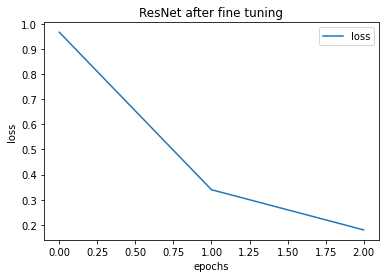

In [21]:
plt.title("ResNet after fine tuning")
plt.plot(history_res_new.history['loss'], label='loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

Loss became better after fine tuning was applied. Still not so good.

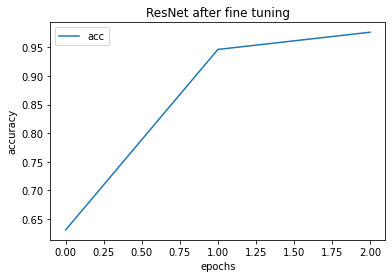

In [22]:
plt.title("ResNet after fine tuning")
plt.plot(history_res_new.history['sparse_categorical_accuracy'], label='acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

Accuracy is improving well. Model still not good as Inception but has a better performance compared to raw version (before fine-tuned) of itself.

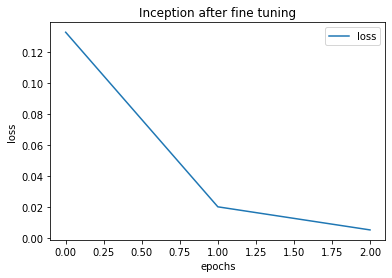

In [23]:
plt.title("Inception after fine tuning")
plt.plot(history_inc_new.history['loss'], label='loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

Loss for Inception after fine tuning looks perfect. Loss is 0 on last epoch which is ideal.

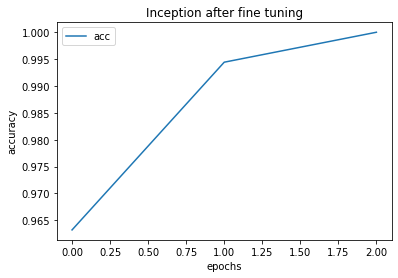

In [24]:
plt.title("Inception after fine tuning")
plt.plot(history_inc_new.history['sparse_categorical_accuracy'], label='acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

Accuracy after fine tuning is incredibly well as it goes to 1. InceptionV3 works incredibly on the mark.

0.jpg


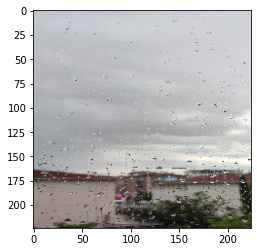

1/1 [==============================] - 2s 2s/step
Tahmin:  Yağmurlu Hava

[0.11523853 0.87574863 0.00358328 0.00542949]

1.jpg


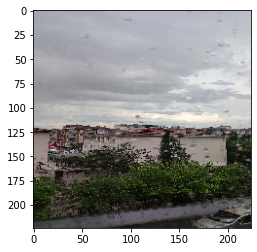

1/1 [==============================] - 0s 137ms/step
Tahmin:  Yağmurlu Hava

[0.37049726 0.6053933  0.00308367 0.02102579]

10.jpg


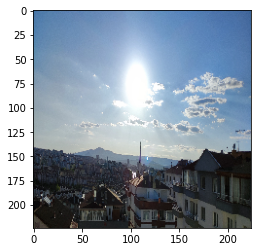

1/1 [==============================] - 0s 143ms/step
Tahmin:  Açık ve Güneşli Hava

[1.0370581e-04 8.2426632e-05 9.2562145e-01 7.4192427e-02]

11.jpg


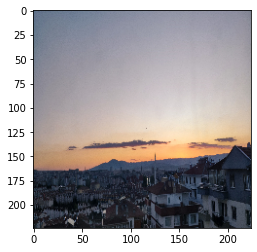

1/1 [==============================] - 0s 138ms/step
Tahmin:  Gün doğumu/Gün batımı

[6.6542864e-04 9.2320524e-06 8.1326021e-04 9.9851197e-01]

12.jpg


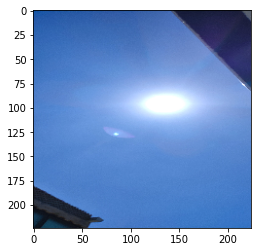

1/1 [==============================] - 0s 136ms/step
Tahmin:  Açık ve Güneşli Hava

[1.0130847e-04 8.7693152e-05 9.6916986e-01 3.0641103e-02]

13.jpg


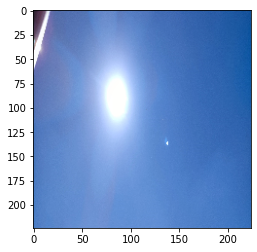

1/1 [==============================] - 0s 137ms/step
Tahmin:  Açık ve Güneşli Hava

[2.1346497e-05 1.5014333e-04 9.7518617e-01 2.4642268e-02]

14.jpg


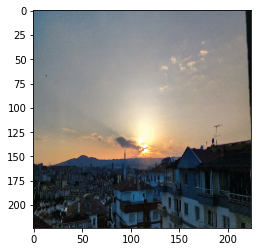

1/1 [==============================] - 0s 137ms/step
Tahmin:  Gün doğumu/Gün batımı

[1.2777877e-05 1.1041632e-06 5.8352638e-05 9.9992776e-01]

15.jpg


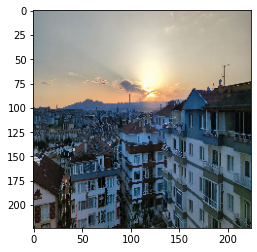

1/1 [==============================] - 0s 138ms/step
Tahmin:  Gün doğumu/Gün batımı

[2.3015702e-04 7.4511662e-04 9.7568263e-04 9.9804902e-01]

16.jpg


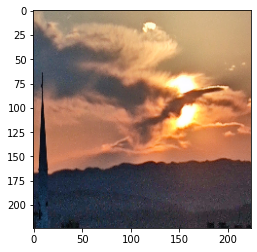

1/1 [==============================] - 0s 136ms/step
Tahmin:  Gün doğumu/Gün batımı

[8.0242530e-03 5.2367926e-07 3.7729136e-05 9.9193758e-01]

17.jpg


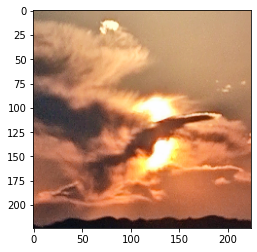

1/1 [==============================] - 0s 132ms/step
Tahmin:  Gün doğumu/Gün batımı

[5.8079051e-04 4.4517842e-06 4.0732361e-06 9.9941075e-01]

18.jpg


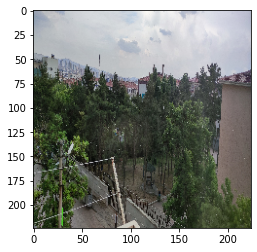

1/1 [==============================] - 0s 136ms/step
Tahmin:  Yağmurlu Hava

[3.8467180e-02 9.5552433e-01 5.7012658e-03 3.0724594e-04]

19.jpg


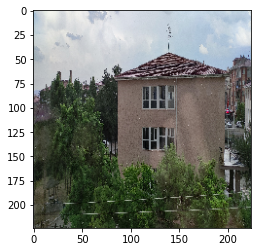

1/1 [==============================] - 0s 129ms/step
Tahmin:  Yağmurlu Hava

[0.01103935 0.96797454 0.01238769 0.00859841]

2.jpg


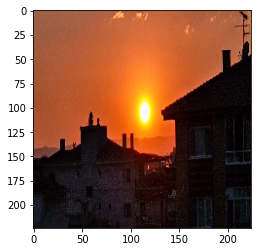

1/1 [==============================] - 0s 136ms/step
Tahmin:  Gün doğumu/Gün batımı

[4.1280906e-05 2.5742404e-05 4.4138134e-05 9.9988878e-01]

20.jpg


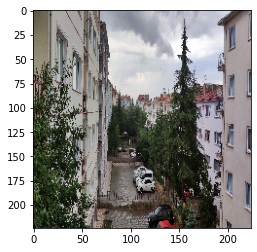

1/1 [==============================] - 0s 135ms/step
Tahmin:  Yağmurlu Hava

[6.3138991e-04 9.9917310e-01 1.5750050e-04 3.8054935e-05]

21.jpg


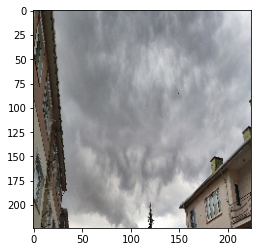

1/1 [==============================] - 0s 131ms/step
Tahmin:  Bulutlu hava

[9.9727887e-01 1.9751329e-03 2.6060131e-04 4.8539633e-04]

22.jpg


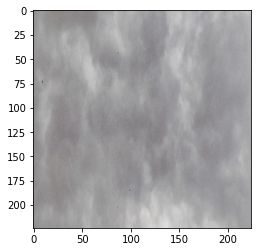

1/1 [==============================] - 0s 136ms/step
Tahmin:  Bulutlu hava

[0.86072046 0.13705459 0.00093167 0.00129331]

23.jpg


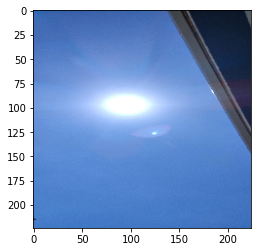

1/1 [==============================] - 0s 134ms/step
Tahmin:  Açık ve Güneşli Hava

[2.4903304e-04 1.9857468e-04 9.8656982e-01 1.2982631e-02]

3.jpg


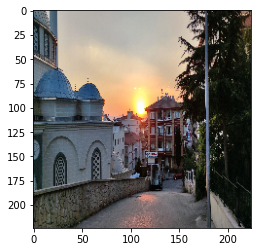

1/1 [==============================] - 0s 131ms/step
Tahmin:  Gün doğumu/Gün batımı

[1.2492443e-03 1.3622500e-02 1.8110250e-04 9.8494720e-01]

4.jpg


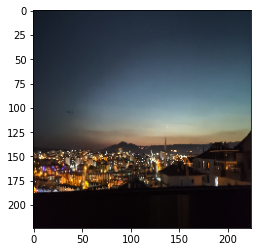

1/1 [==============================] - 0s 134ms/step
Tahmin:  Gün doğumu/Gün batımı

[0.23539227 0.08127786 0.01689535 0.6664346 ]

5.jpg


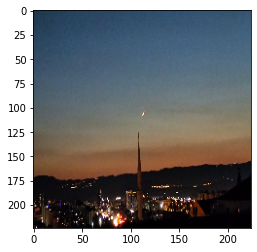

1/1 [==============================] - 0s 131ms/step
Tahmin:  Gün doğumu/Gün batımı

[0.41935354 0.01384522 0.03950901 0.52729225]

6.jpg


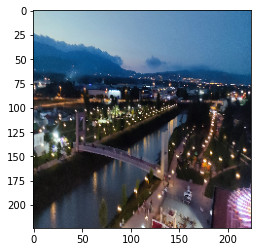

1/1 [==============================] - 0s 140ms/step
Tahmin:  Yağmurlu Hava

[0.18356359 0.45394138 0.306919   0.05557609]

7.jpg


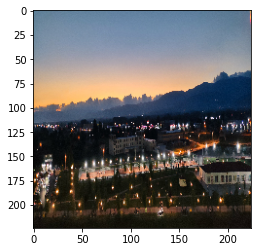

1/1 [==============================] - 0s 132ms/step
Tahmin:  Gün doğumu/Gün batımı

[0.02088067 0.0120814  0.00428475 0.9627532 ]

8.jpg


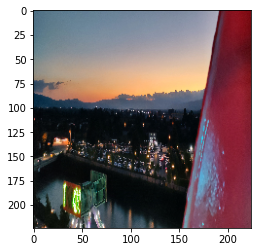

1/1 [==============================] - 0s 140ms/step
Tahmin:  Gün doğumu/Gün batımı

[0.09145359 0.22596453 0.10063338 0.58194846]

9.jpg


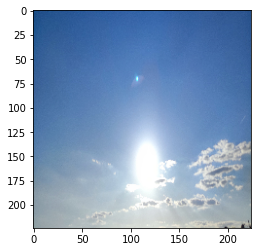

1/1 [==============================] - 0s 143ms/step
Tahmin:  Gün doğumu/Gün batımı

[1.0663565e-04 1.2385273e-04 2.9182503e-01 7.0794445e-01]



In [14]:
# Load model
model_inc = keras.models.load_model('saved_models/weather_pred_model_inc')
# Test the model with different images

path = f'predict_images/'
imgs = os.listdir(path)

labels_tr = ["Bulutlu hava", "Yağmurlu Hava", "Açık ve Güneşli Hava", "Gün doğumu/Gün batımı"]


# For loop to read a specific folder
for img_path in imgs:
    print(img_path)

    img_path = path + img_path
    img = image.load_img(img_path, target_size=(224, 224))
    
    plt.imshow(img)
    plt.show()
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    img = np.array(x, dtype="object")
    
    predictions = model_inc.predict(x)
    
    predictions = predictions[0]
    
    max = -1
    ind = -1
    
    for i in range (len(predictions)):
        if predictions[i] > max:
            max = predictions[i]
            ind = i
            
    pred = labels_tr[ind]
    print("Tahmin: ", pred)
    print()
    print(predictions)
    print()
